In [ ]:
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import label_ranking_average_precision_score
from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import math

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
encoder = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
genreToIndex = {
    "Drama": 0,
    "Comedy": 1,
    "Thriller": 2,
    "Action": 3,
    "Romance": 4,
    "Adventure": 5,
    "Crime": 6,
    "Science Fiction": 7,
    "Horror": 8,
    "Family": 9,
    "Fantasy": 10,
    "Mystery": 11,
    "Animation": 12,
    "History": 13,
    "Music": 14,
    "War": 15,
    "Documentary": 16,
    "Western": 17,
    "Foreign": 18,
    "TV Movie": 19
}

indexToGenre = [
    "Drama",
    "Comedy",
    "Thriller",
    "Action",
    "Romance",
    "Adventure",
    "Crime",
    "Science Fiction",
    "Horror",
    "Family",
    "Fantasy",
    "Mystery",
    "Animation",
    "History",
    "Music",
    "War",
    "Documentary",
    "Western",
    "Foreign",
    "TV Movie"
]

In [ ]:
# make sure to change this for your path
df = pd.read_csv('tmdb.csv')
df.head(1)

,Unnamed: 0,budget,genres,homepage,id,keywords,original_language,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [ ]:
def one_hot_encode_genres(df):
  labels = []
  for genres in df["genres"]:
    genreList = json.loads(genres)
    label = [0 for _ in range(len(indexToGenre))]
    for genre in genreList:
      genreName = genre["name"]
      genreIndex = genreToIndex[genreName]
      label[genreIndex] = 1
    labels.append(label)
  return labels

In [ ]:
def get_keywords(df):
  keyword_entries = []
  for keywords in df['keywords']:
    keywords_list = json.loads(keywords)
    current_keywords = ' '.join([keyword['name'] for keyword in keywords_list])
    keyword_entries.append(current_keywords)
  return pd.Series(keyword_entries)

In [ ]:
def build_df(df, column_names):
  # filling missing values (overview, tagline, runtime)
  features = []
  overviews = df["overview"].fillna("")
  taglines = df["tagline"].fillna("")
  keywords = get_keywords(df)
  titles = df["title"]
  
  text_col = np.array(encoder(overviews + taglines + keywords + titles))
  features.append(list(text_col))

  runtime_avg = df['runtime'].mean()
  features.append(list(df["runtime"].fillna(runtime_avg)))
  features.append(list(df["popularity"]))
  
  vote_avg_avg = df['vote_average'].mean()
  features.append(list(df["vote_average"].fillna(vote_avg_avg)))
  vote_count_avg = df['vote_count'].mean()
  features.append(list(df["vote_count"].fillna(vote_count_avg)))

  # OHC for labels
  features.append(one_hot_encode_genres(df))

  new_df = pd.DataFrame()
  for i in range(len(features)):
    column = column_names[i]
    new_df[column] = features[i]

  return new_df

In [ ]:
def show_confusion_graph(y_true, y_pred):
  cols = 4
  conf_mat = multilabel_confusion_matrix(y_true, y_pred)
  genres_count = len(indexToGenre)
  figures_count = int(math.ceil(genres_count / cols))
  for figure_idx in range(figures_count):
    fig, axs = plt.subplots(1, cols, figsize=(16, 3))
    genre_idx = figure_idx * cols
    offset = 0
    while offset < cols and genre_idx + offset < genres_count:
      col = offset
      mat = conf_mat[genre_idx + offset]
      tn = mat[0, 0] # True Negatives
      fp = mat[0, 1] # False Positives
      fn = mat[1, 0] # False Negatives
      tp = mat[1, 1] # True Positives
      names = ["TP", "FP", "FN", "TN"]
      values = [tp, fp, fn, tn]
      axs[col].bar(names, values)
      axs[col].set_title(indexToGenre[genre_idx + offset])
      offset += 1
    plt.show()

def show_confusion_matrix(y_true, y_pred):
    print("Confusion Matrix for each genre")
    print("Format: ")
    print(np.array([["True Positives", "False Positives"],
                    ["False Negatives", "True Negatives"]]))
    conf_mat = multilabel_confusion_matrix(y_true, y_pred)
    for i in range(len(indexToGenre)):
      genre = indexToGenre[i]
      mat = conf_mat[i]
      tn = mat[0, 0] # True Negatives
      fp = mat[0, 1] # False Positives
      fn = mat[1, 0] # False Negatives
      tp = mat[1, 1] # True Positives
      print()
      print(genre)
      print(np.array([[tp, fp], [fn, tn]]))

In [ ]:
def train_models(X, y, models):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

  trained_models = []
  for model in models:
    print(f"Training {type(model).__name__}...")
    training_result = OneVsRestClassifier(model).fit(X_train, y_train)
    trained_models.append(training_result)
  
  return X_train, X_test, y_train, y_test, trained_models

In [ ]:
def test_models(X_test, y_test, trained_models):
  for model in trained_models:
    y_predict = model.predict(X_test)
    score = label_ranking_average_precision_score(y_test, y_predict)
    print(f"{type(model.estimator).__name__} tested with score: {score}")

    show_confusion_graph(y_test, y_predict)
    #show_confusion_matrix(y_test, y_predict)

In [ ]:
new_df = build_df(
    df,
    ['text', 'runtime', 'popularity', 'vote_average', 'vote_count', 'genres']
)
new_df

,text,runtime,popularity,vote_average,vote_count,genres
0,"[-0.047631506, 0.0011049578, -0.0030031963, -0...",162.0,150.437577,7.2,11800,"[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, ..."
1,"[-0.029288016, -0.024092436, -0.033369757, -0....",169.0,139.082615,6.9,4500,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
2,"[-0.01410443, 0.019948822, -0.06397616, -0.052...",148.0,107.376788,6.3,4466,"[0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0.010828347, -0.03850771, -0.007529563, -0.01...",165.0,112.312950,7.6,9106,"[1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[-0.049101423, 0.02820155, -0.028164482, -0.01...",132.0,43.926995,6.1,2124,"[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
4770,"[-0.053809147, 0.017645368, 0.05494192, 0.0080...",80.0,0.022173,7.5,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4771,"[-0.022440527, 0.02026402, 0.06935676, -0.0040...",81.0,14.269792,6.6,238,"[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4772,"[0.019236598, 0.05546636, -0.014909614, -0.002...",85.0,0.642552,5.9,5,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4773,"[-0.05435342, -0.06341676, -0.06609998, -0.009...",120.0,1.444476,7.0,6,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
text = np.array(new_df['text'].tolist())
popularity = pd.DataFrame(new_df['popularity'])
runtime = pd.DataFrame(new_df['runtime'])
vote_average = pd.DataFrame(new_df['vote_average'])
vote_count = pd.DataFrame(new_df['vote_count'])

X_basic = np.concatenate((text, popularity, runtime), axis=1)
X_full = np.concatenate((text, popularity, runtime, vote_average, vote_count), axis=1)

# formatting y for OneVsRestClassifier
y = np.array(list(new_df["genres"]))

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.metrics import label_ranking_average_precision_score, multilabel_confusion_matrix

models = [
    DecisionTreeClassifier(),
    SVC(),
    MLPClassifier(max_iter=1000),
    KNeighborsClassifier(),
    RandomForestClassifier(),
    SGDClassifier(),
    RidgeClassifier()
]

In [ ]:
# Train the models on the small feature set
X_basic_train, X_basic_test, y_basic_train, y_basic_test, basic_trained_models = train_models(X_basic, y, models)

Training DecisionTreeClassifier...
Training SVC...
Training MLPClassifier...
Training KNeighborsClassifier...
Training RandomForestClassifier...
Training SGDClassifier...
Training RidgeClassifier...


In [ ]:
# Train the models on the extended feature set
X_train, X_test, y_train, y_test, trained_models = train_models(X_full, y, models)

Training DecisionTreeClassifier...
Training SVC...
Training MLPClassifier...
Training KNeighborsClassifier...
Training RandomForestClassifier...
Training SGDClassifier...
Training RidgeClassifier...


DecisionTreeClassifier tested with score: 0.3666628230698916


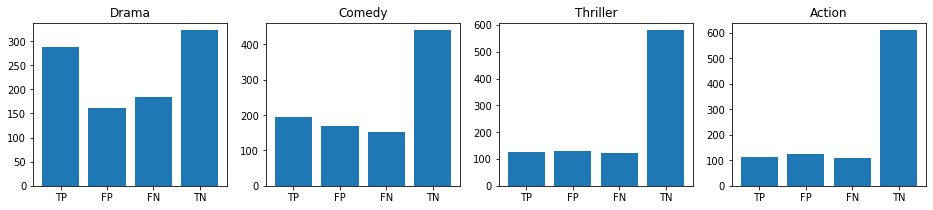

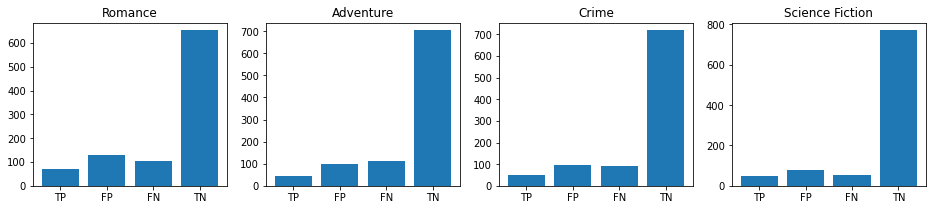

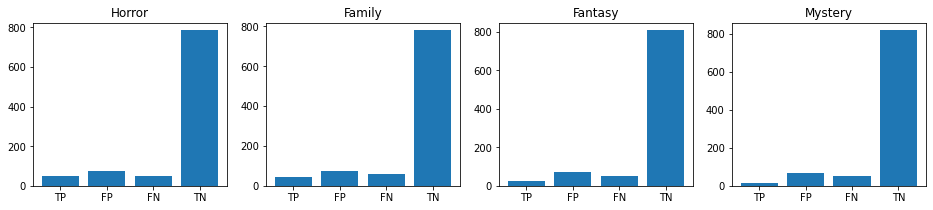

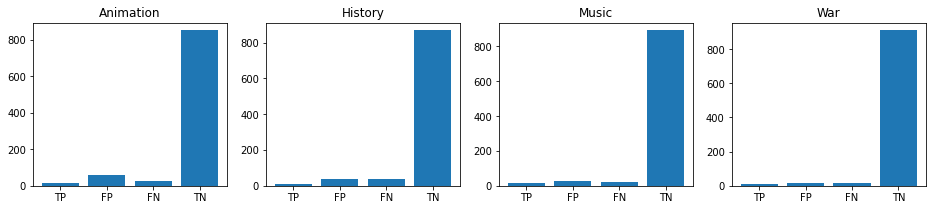

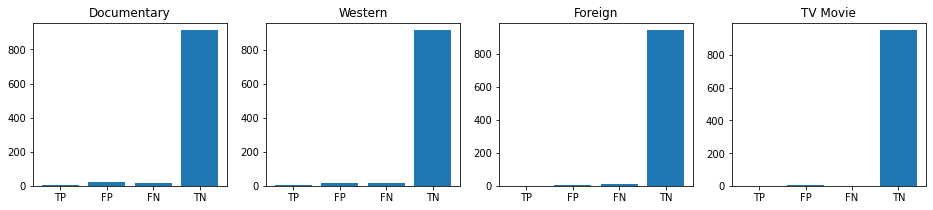

SVC tested with score: 0.2594851657940673


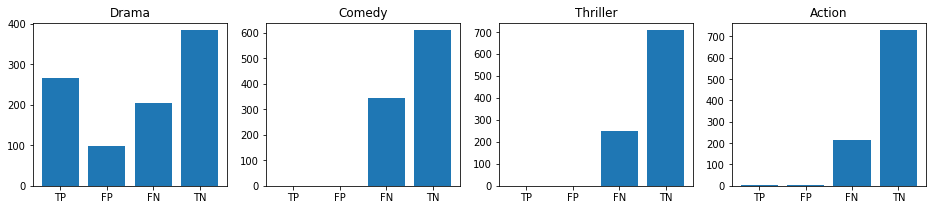

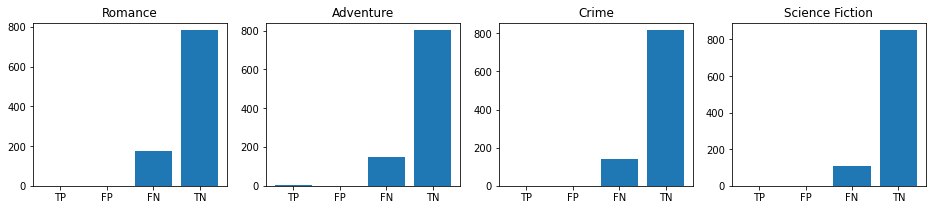

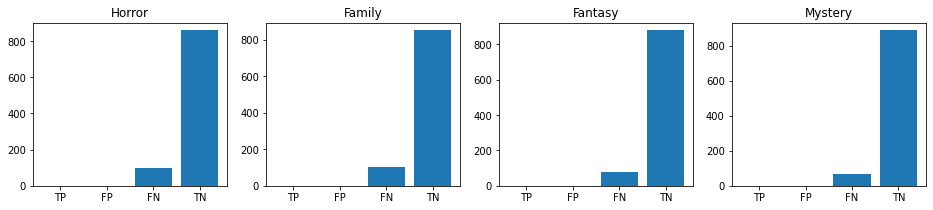

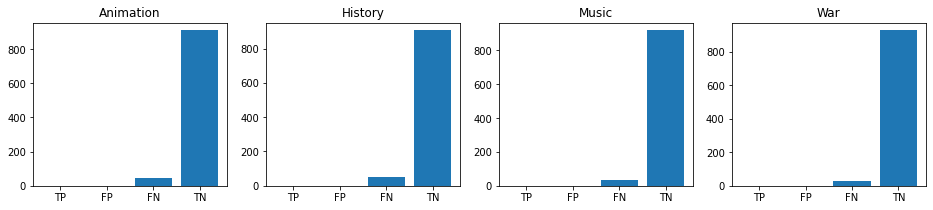

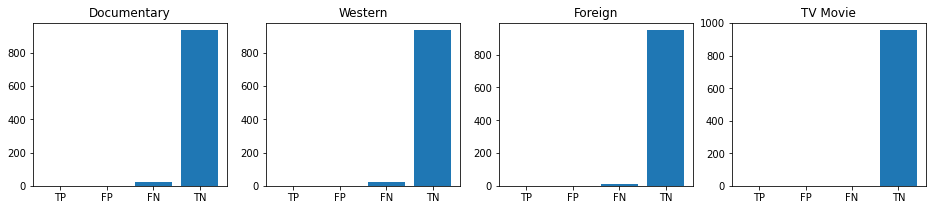

MLPClassifier tested with score: 0.5240613728912169


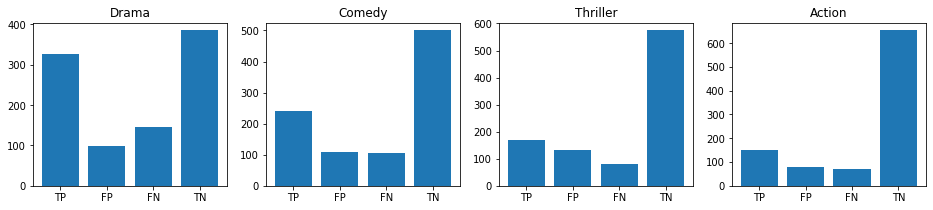

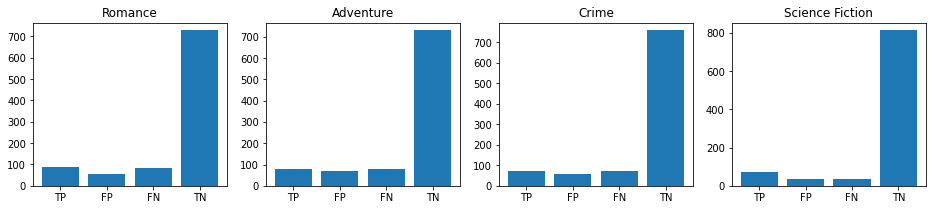

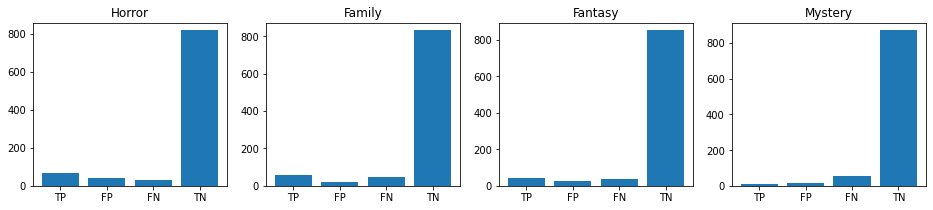

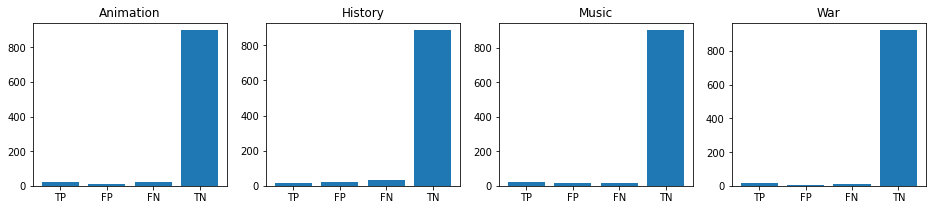

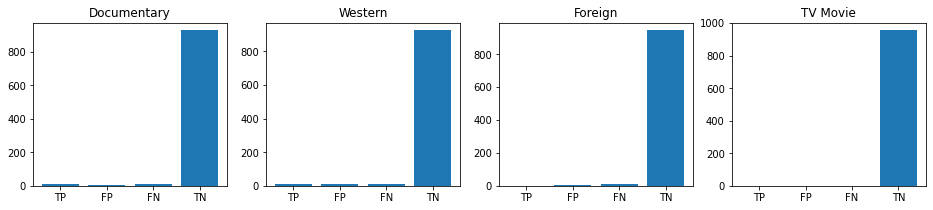

KNeighborsClassifier tested with score: 0.32971931355439327


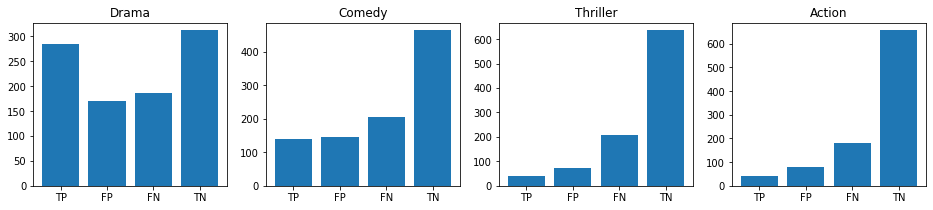

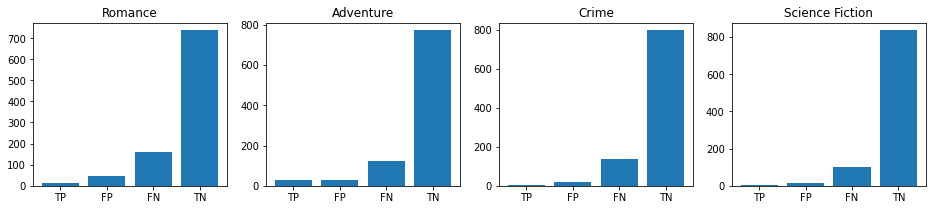

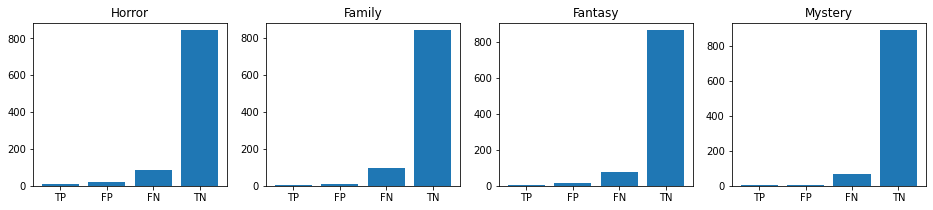

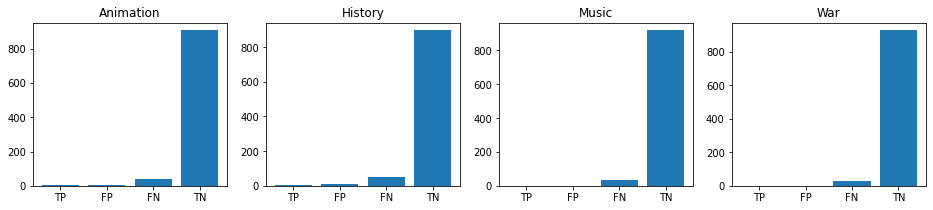

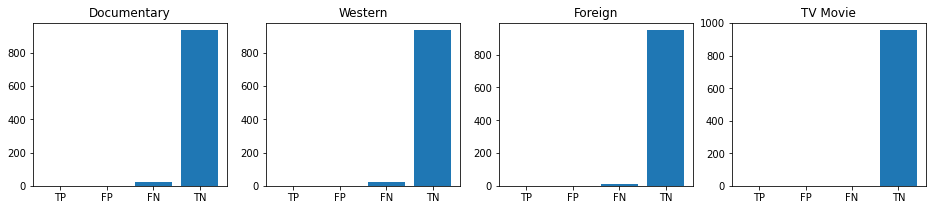

RandomForestClassifier tested with score: 0.46930773705642953


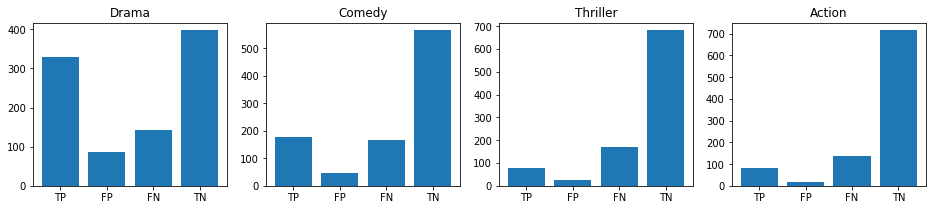

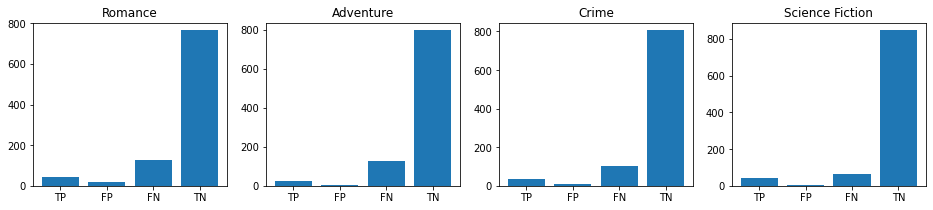

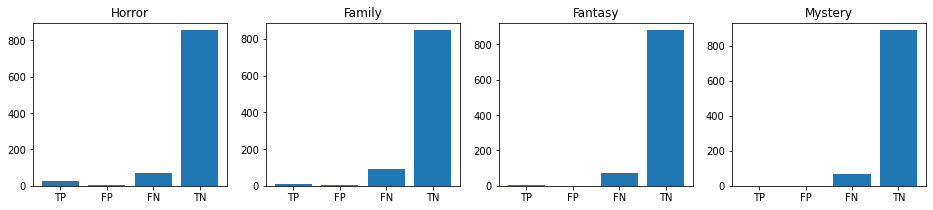

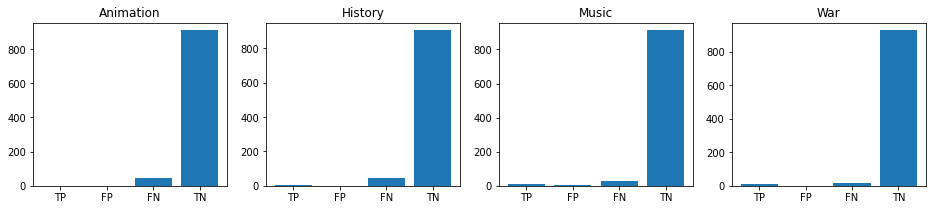

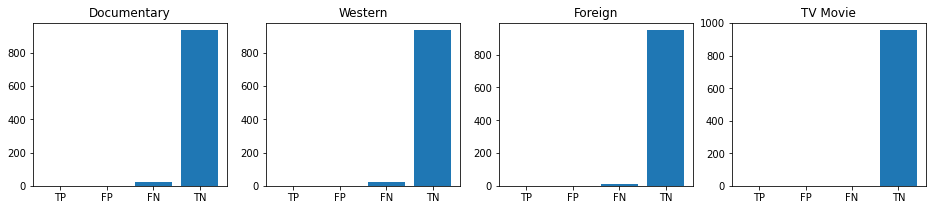

SGDClassifier tested with score: 0.18883944153577711


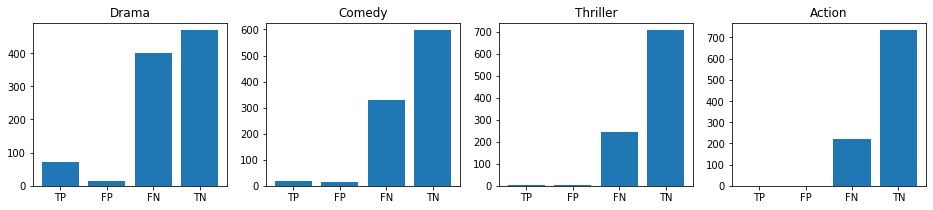

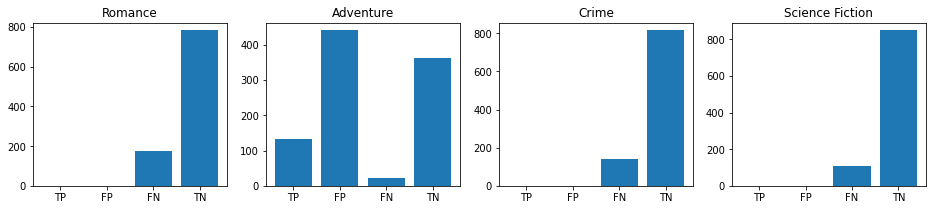

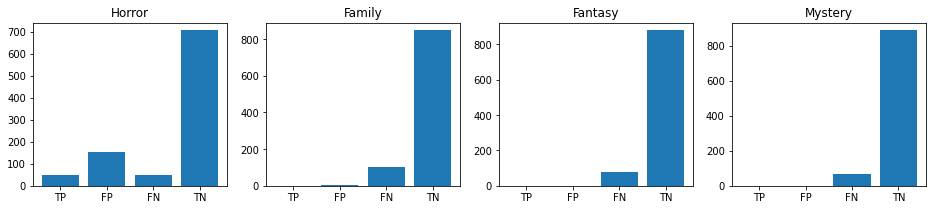

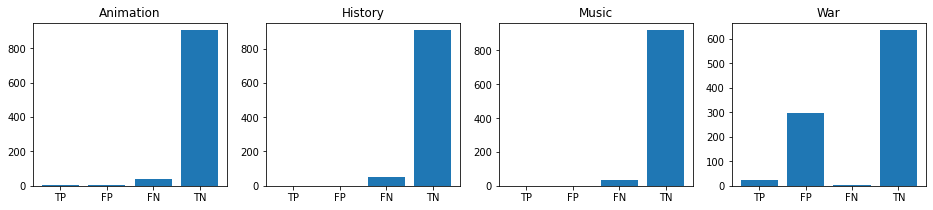

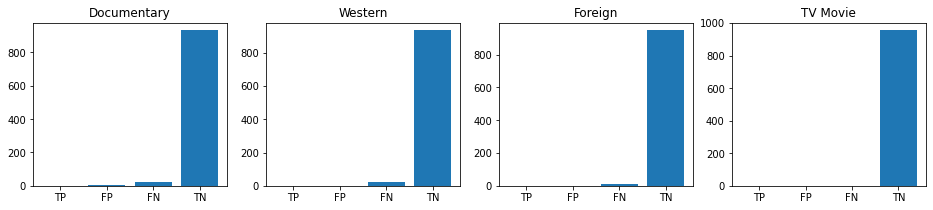

RidgeClassifier tested with score: 0.540065445026179


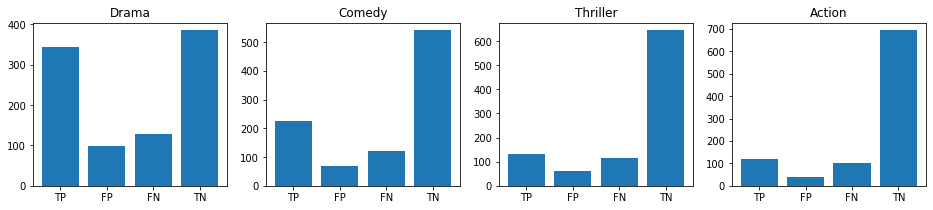

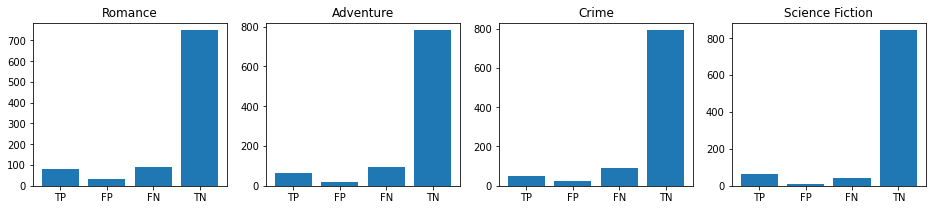

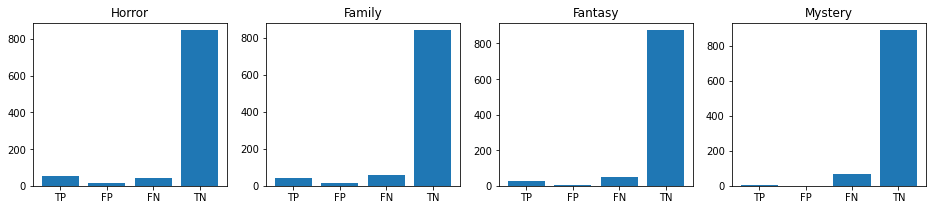

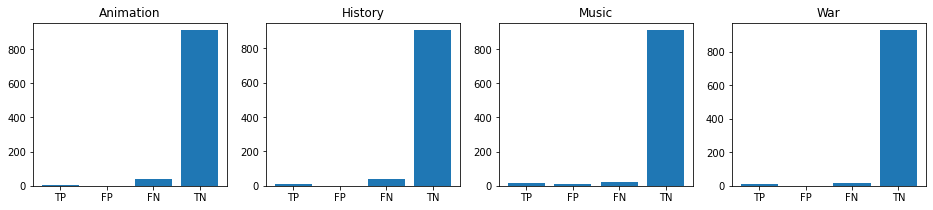

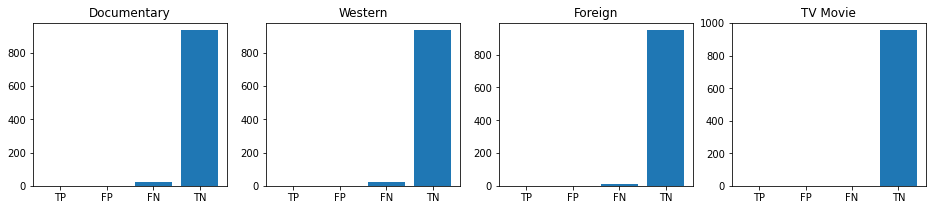

In [ ]:
# Test the models on the small feature set
test_models(X_basic_test, y_basic_test, basic_trained_models)

DecisionTreeClassifier tested with score: 0.3767065569683385


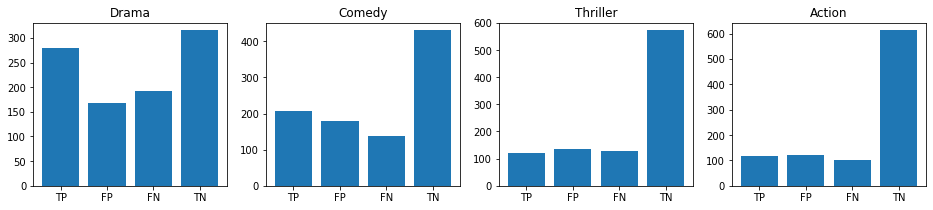

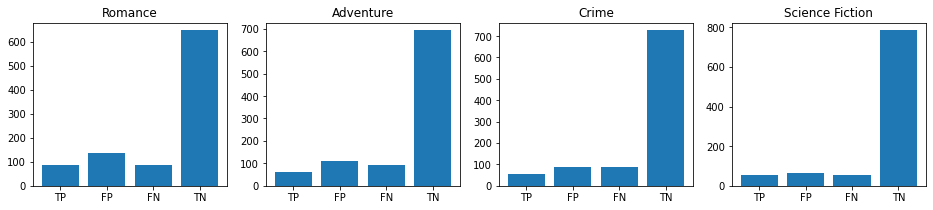

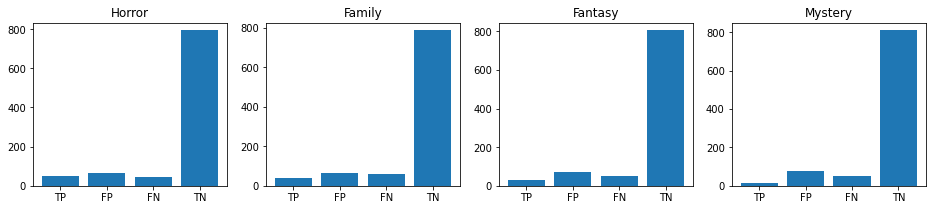

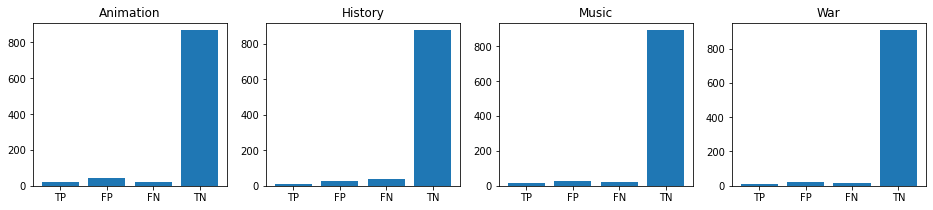

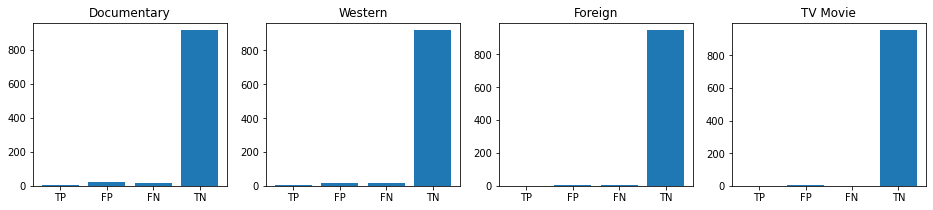

SVC tested with score: 0.2797120418848179


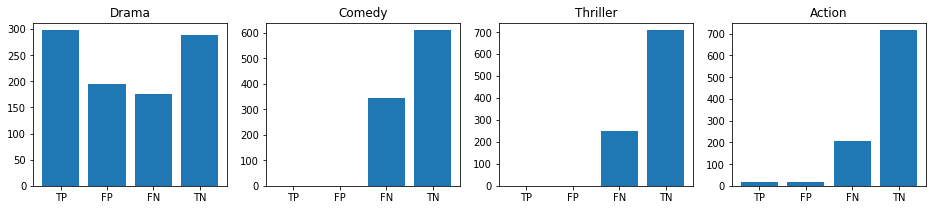

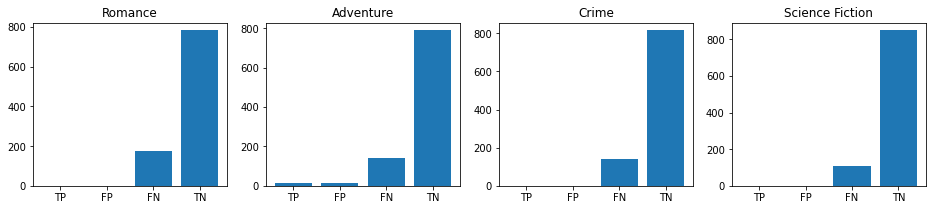

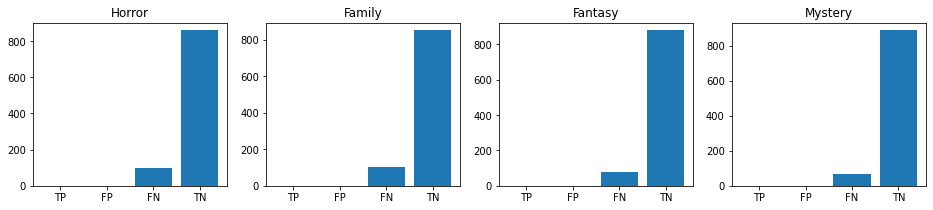

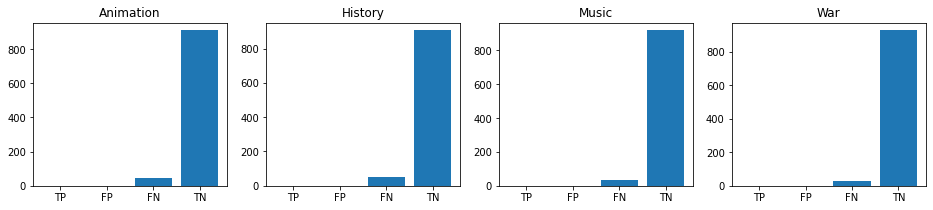

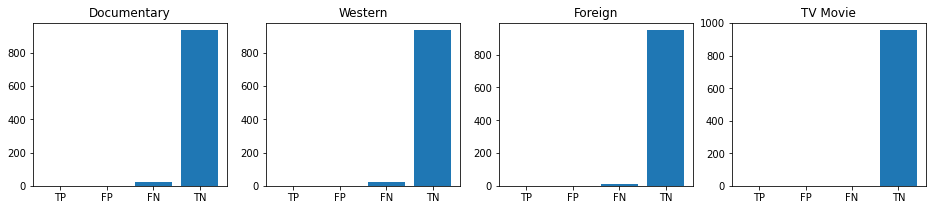

MLPClassifier tested with score: 0.5295546414028102


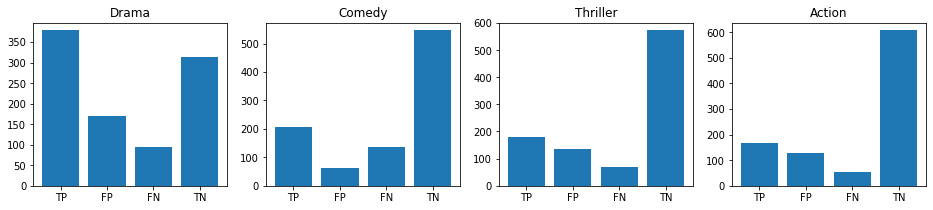

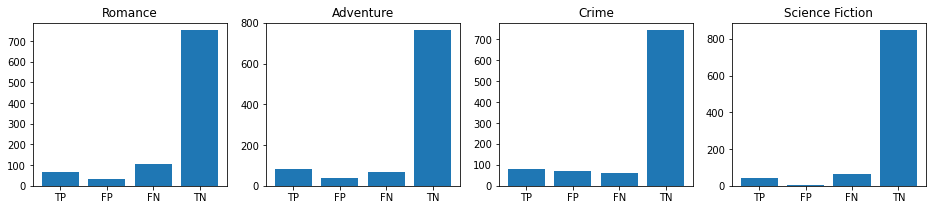

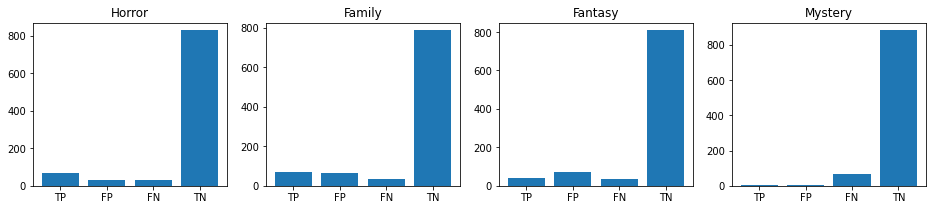

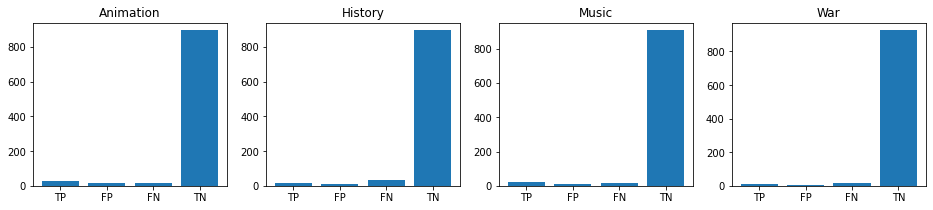

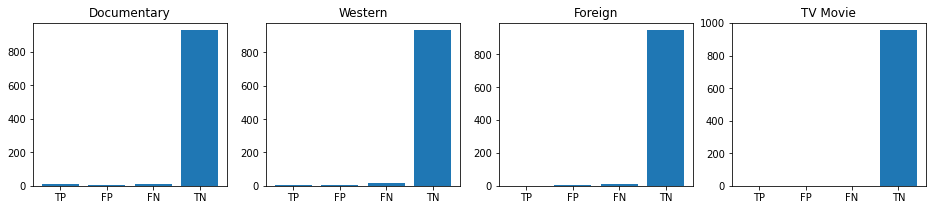

KNeighborsClassifier tested with score: 0.3117044793484597


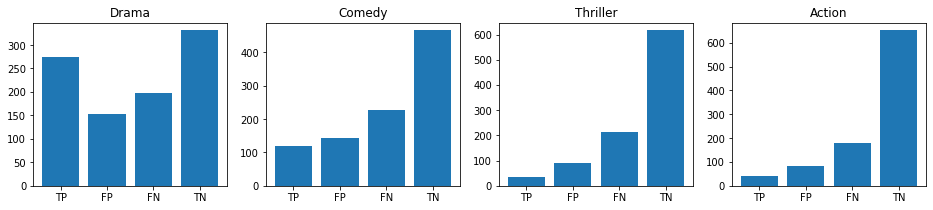

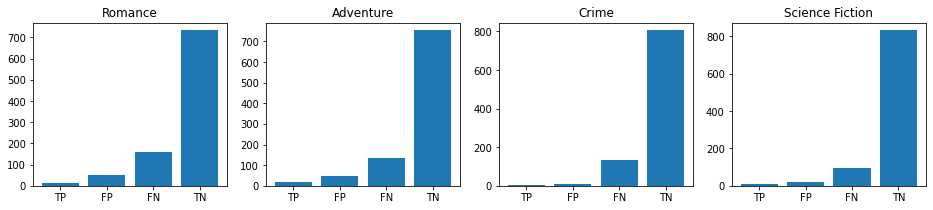

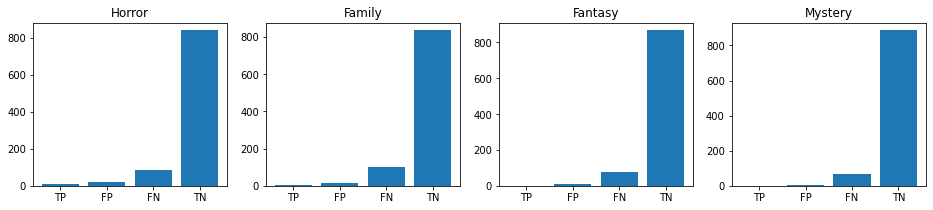

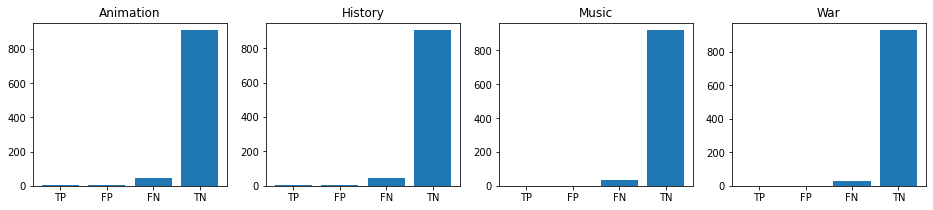

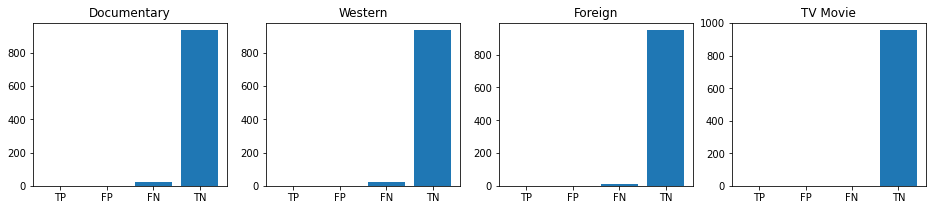

RandomForestClassifier tested with score: 0.4618877254217582


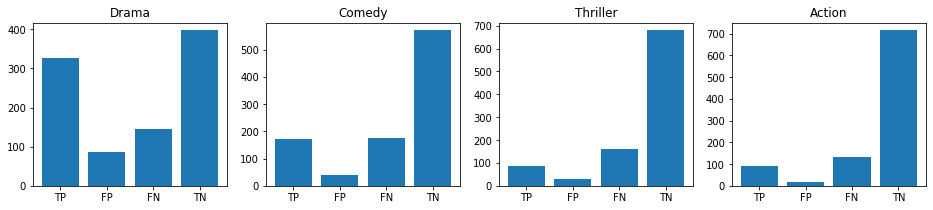

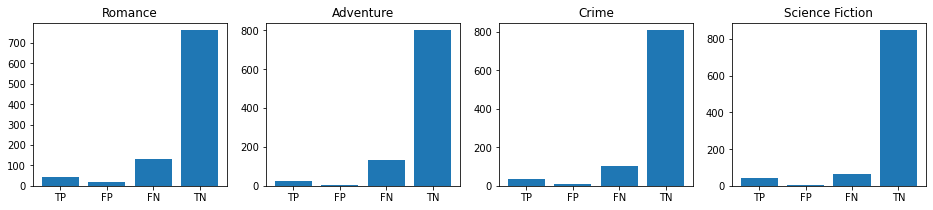

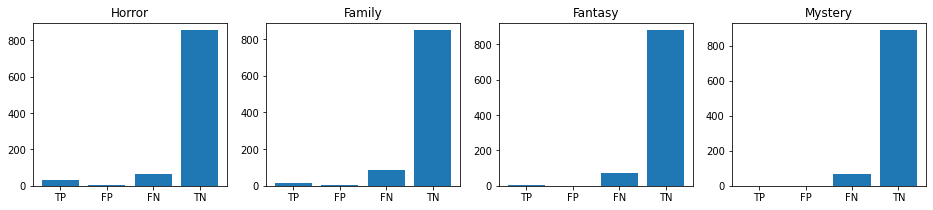

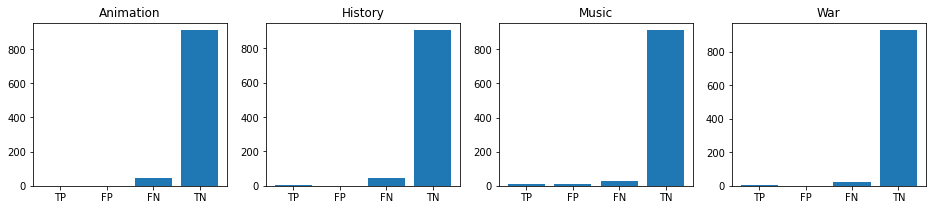

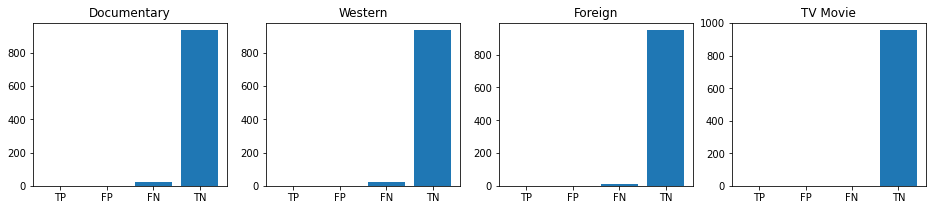

SGDClassifier tested with score: 0.17632801462644407


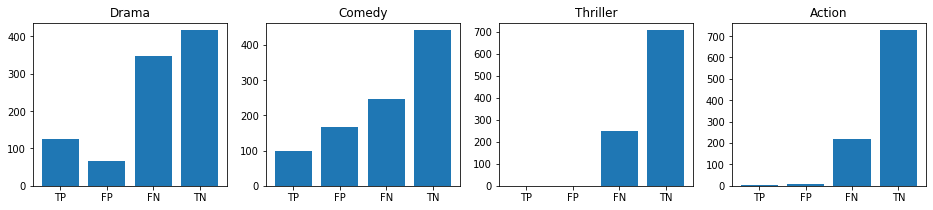

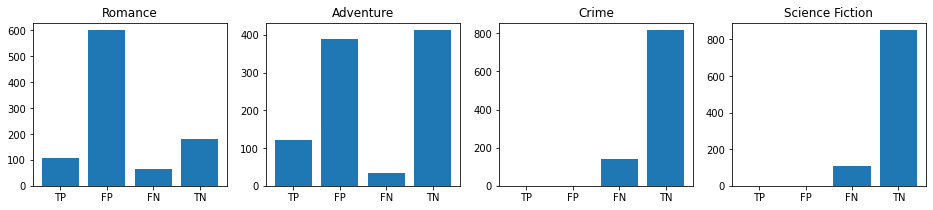

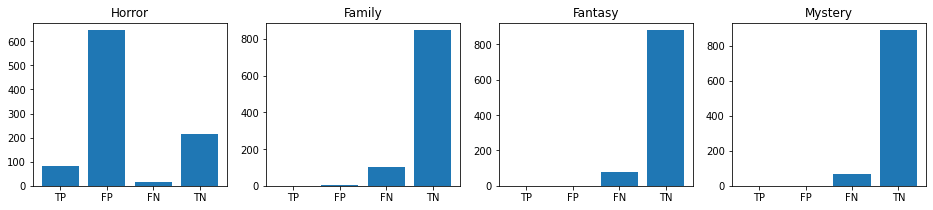

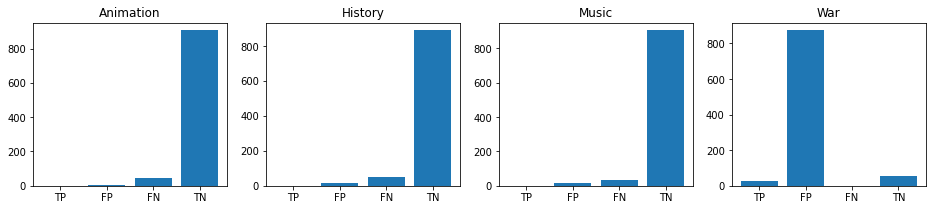

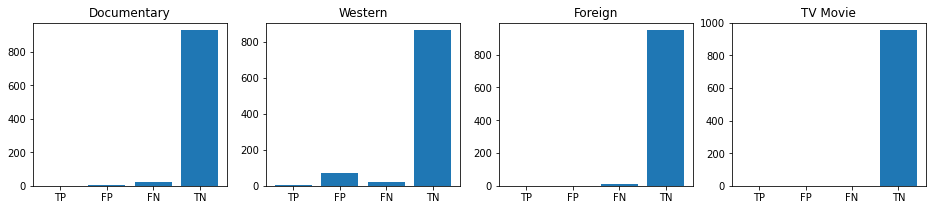

RidgeClassifier tested with score: 0.5389790575916241


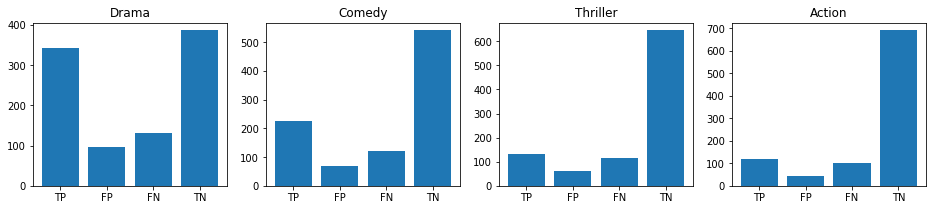

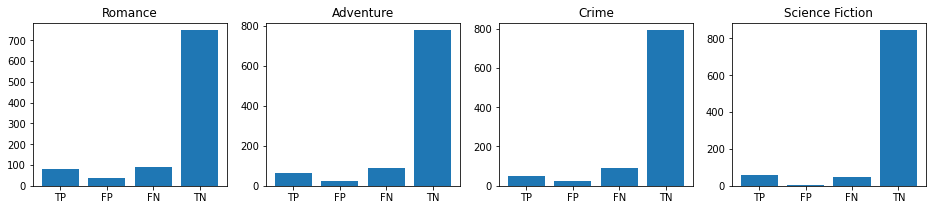

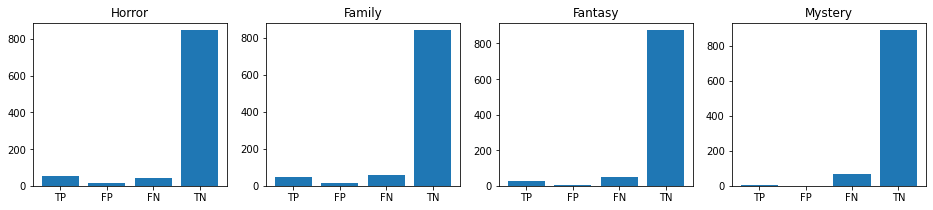

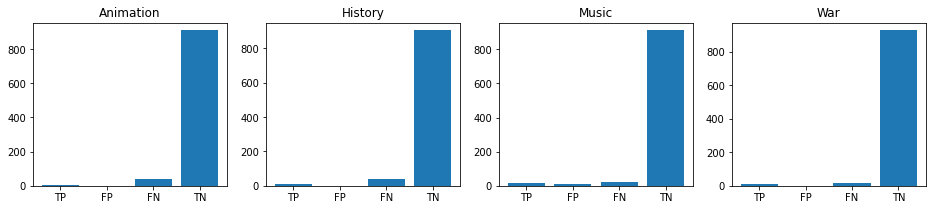

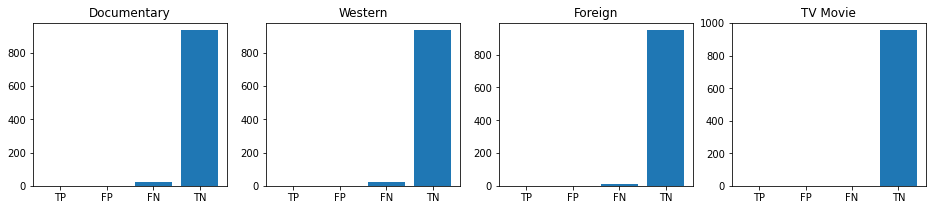

In [ ]:
# Test the models on the extended feature set
test_models(X_test, y_test, trained_models)